<a href="https://colab.research.google.com/github/tianlangxingaerfa/Python/blob/main/Lab2_CircuitModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

This week we will begin working on ways to test our models to see if they are robust. Last week you may have seen that Ohm's law only applies for resistors (with a potential of an offset). The easiest way to test a model is to see the range at which it holds. In this lab we will explore a range of resistors to see if Ohm's law applies in all cases of resistors. You will be given a small collection of resistors to test, which makes part of the larger scale measured by the whole class.

## Safety reminders
Be careful while handling the electrical equipment. Electrical currents can be harmful to some materials or dangerous to you.

The Digital Multimeters (DMMs) have a current limit indicated on the current terminals of the device. <font color='red'>Do not excede these current limits.</font>

# 2. Experimental Results and Data Analysis Resources

In [1]:
# Initialize any python packages and user-made functions here

## HERE WE HAVE SOME SUGGESTED FUNCTIONS IF YOU WANT TO USE THEM
import numpy as np
#import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
matplotlib.rcParams.update({'font.size': 12})

def chisquare(data_y,model_y,uncertainty):
    '''
    Calculates value of chi squared for model y-values given data y-values and uncertainty

    Parameters
    ----------
    data_y : numpy array
            1D vector of data values (dependent variable)
    model_y : numpy array
            1D vector of corresponding values predicted by model
    uncertainty : numpy array
            1D vector of uncertainty corresponding to data
    Returns
    -------
    x2 : float
       Returns value of chi squared for this model given data and uncertainty
    '''
    x2 = np.sum((data_y-model_y)**2/uncertainty**2)
    return x2

def mycurvefit(func,XX,YY,XX_UNCERT,YY_UNCERT,xlabel=None,ylabel=None,p0=None,X2_cont=False):
    '''
    params, param_errs = mycurvefit(func = , XX = , YY = , XX_UNCERT = , YY_UNCERT = ,
        xlabel='mass (g)', ylabel='y (cm)', p0=p0) #Change FUNC and p0

    Fits data (XX, YY, UNCERT) to function using scipy.curvefit, and then plots data and best fit
        Parameters
    ----------
    func : user-defined function
            Model to be used to fit data
    XX : numpy array
            1D vector of data's independent variable
    YY : numpy array
            1D vector of data's dependent variable
    XX_UNCERT : numpy array
            1D vector of uncertainty in XX
    YY_UNCERT : numpy array
            1D vector of uncertainty in YY
    xlabel : string
            label for plot's x-axis
    ylabel : string
            label for plot's y-axis
    X2_cont : Boolean (False = default)
            Turns on or off the contour plots for chi-squared
    '''

    ##################################################
    #                Do the curve fit                #
    ##################################################

    # To get curve_fit to use UNCERT, set absolute_sigma = True.  Otherwise sigma = 1
    fitparams,pcov = curve_fit(func,XX,YY,sigma=YY_UNCERT,absolute_sigma=True, p0=p0)

    # Find error in each parameter.  Assumes covariance matrix is roughly diagonal.
    fiterrs = np.sqrt(np.diag(pcov))

    ##################################################
    #                Begin Plotting                  #
    ##################################################

    fig,ax = plt.subplots()
    # plot the raw data
    plt.errorbar(XX,YY,xerr=XX_UNCERT,yerr=YY_UNCERT,fmt='.',label='data')

    # plot the fit
    XX_shade = np.linspace(min(XX),max(XX),100)
    plt.plot(XX_shade,func(XX_shade,*fitparams),'k-',label = 'best fit')

    if xlabel == None:
      xlabel = ''
    if ylabel == None:
      ylabel = ''

    # make the plot nice
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='both', direction='in', top=True, right=True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    ##################################################
    #           Plot the chisqred contours           #
    ##################################################
    if X2_cont == True:
        # define the minimum chi square value readily
        chisqmin = chisquare(YY,func(XX,*fitparams),YY_UNCERT)
        A_best = fitparams[0]
        B_best = fitparams[1]
        sigma_A = np.sqrt(pcov[1][1])
        sigma_B = np.sqrt(pcov[0][0])
        rho = pcov[0][1]/(sigma_A*sigma_B)

        # define chi-squared plot interval
        A_interval = np.sqrt(6.17 * sigma_A**2/(1 - rho**2))
        B_interval = np.sqrt(6.17 * sigma_B**2/(1 - rho**2))
        AB_interval = [A_best-1.1*A_interval, A_best+1.1*A_interval, B_best-1.1*B_interval, B_best+1.1*B_interval]

        # Contour plot
        fig, ax = plt.subplots()
        def paraboloid(A, B):
            return (A - A_best)**2/sigma_A**2 + (B - B_best)**2/sigma_B**2 + 2 * rho * (A - A_best) * (B - B_best)/(sigma_A * sigma_B)
        X, Y = np.meshgrid(np.linspace(AB_interval[0], AB_interval[1], 200), np.linspace(AB_interval[2], AB_interval[3], 200))
        Z = paraboloid(X, Y)
        CS1 = plt.contour(X, Y, Z, levels=[2.3, 3.17])

        plt.plot(A_best, B_best, 'o', markersize=4, color='k',label='Best estimate')
        plt.xlabel('P1')
        plt.ylabel('P2')

        fmt = {}
        strs = [r'1 $\sigma$', r'2 $\sigma$']
        for l, s in zip(CS1.levels, strs):
            fmt[l] = s

        # Label every other level using strings
        ax.clabel(CS1, CS1.levels[::1], inline=True, fmt=fmt, fontsize=10)
        plt.legend()
        plt.tight_layout()

    ##################################################
    #    Calculate and display the fit metrics       #
    ##################################################

    # calculate the number of degrees of freedom
    shape = np.shape(XX)
    dof = shape[0] - len(fitparams)

    # print out the parameters and errors on them
    print('Best Fit Parameters:\n')
    i = 0
    for A,sigA in zip(fitparams, fiterrs):
        i = i + 1
        mystring = '\t P' + str(i) + ' = '
        print(mystring,round(A,4),'+/-',round(sigA,4))

    print('\n Fit Metrics:\n')
    print('\t Degrees of freedom: ', dof)

    X2 = chisquare(YY,func(XX,*fitparams),YY_UNCERT)
    X2string = '\t Chi Squared = ' + str(round(X2,2))
    X2redstring = '\t Reduced Chi Squared = '+ str(round(X2/dof,2))
    print(X2string)
    print(X2redstring)
    return fitparams,fiterrs

In [16]:
# Measure the resistance of your resistors
R = np.array([9.9, 30.2, 298.9, 99.7, 1001.1])
# Enter your uncertainty in your resistance
R_err = np.array([0.1, 0.1, 0.1, 0.1, 0.1])

# Collected data for each resistor
V = np.array([15.3, 18.8, 19.6, 19.3, 19.9])
V_err = np.array([0.5, 0.5, 0.5, 0.5, 0.5])

Text(0, 0.5, 'Measured Voltage (V)')

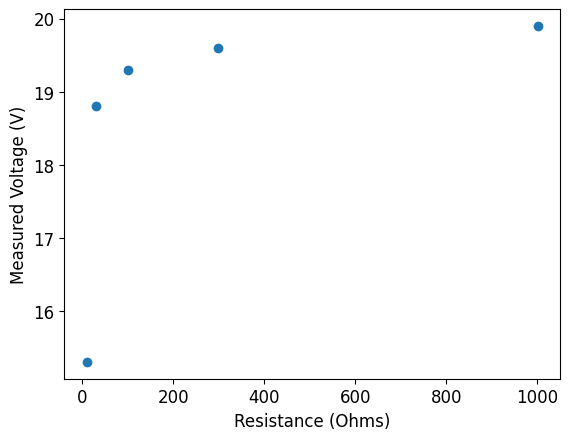

In [17]:
# Plot the data

fig, ax = plt.subplots()
ax.plot(R, V, 'o')
ax.set_xlabel('Resistance (Ohms)')
ax.set_ylabel('Measured Voltage (V)')



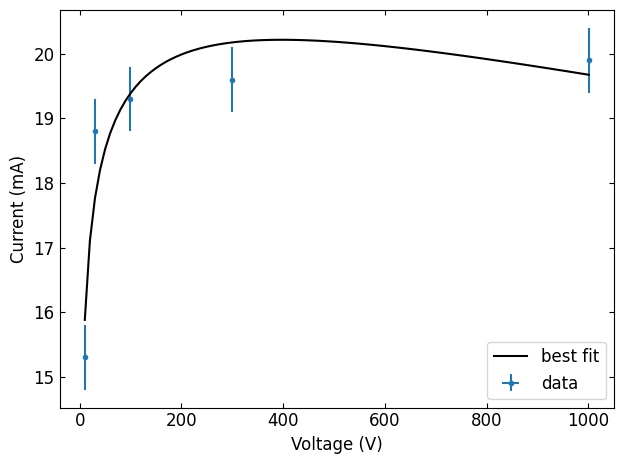

Best Fit Parameters:

	 P1 =  2.1616 +/- 0.4385
	 P2 =  -0.2169 +/- 0.0696
	 P3 =  11.6057 +/- 1.1756

 Fit Metrics:

	 Degrees of freedom:  2
	 Chi Squared = 7.06
	 Reduced Chi Squared = 3.53


In [25]:
# Fit the data to Ohm's law: V = IR

# First write a linear model:
def lin_model(xdata, a, b):
    return a*xdata + b

def log_model(xdata, a, b):
    return a*np.log(xdata) + b*xdata

def sqrt_model(xdata, a, b, c):
    return a*np.sqrt(xdata) + b*xdata + c

def integrated_model(xdata, a, b, d):
    return a*np.log(xdata) + b*np.sqrt(xdata) + d

# Make an initial guess for your parameters
p0 = [20, 10, 10]

# Then do the fit
params, params_err = mycurvefit(func = integrated_model, XX = R, YY = V, XX_UNCERT = R_err, YY_UNCERT = V_err,
                                xlabel='Voltage (V)', ylabel='Current (mA)', p0=p0) #Change FUNC and p0
